# Hypersphere
> Extend decision trees to hyperspherical manifolds!

This code is largely adapted from the 14_fixed_hyperbolic_gaussian.ipynb notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from geomstats.geometry.hypersphere import Hypersphere
from geomstats.visualization import plot as gplot

from hyperdt.tree import HyperbolicDecisionTreeClassifier

INFO: Using numpy backend


In [3]:
# Modified version of hdt class


class HypersphereDecisionTreeClassifier(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _validate_hyperbolic(self, X):
        # Basically just skip the check
        pass

    def _get_candidates(self, X, dim):
        # Consider tangents
        thetas = np.arctan2(X[:, self.timelike_dim], X[:, dim])
        thetas = np.unique(thetas)  # This also sorts
        candidates = (thetas[:-1] + thetas[1:]) / 2
        return candidates

In [4]:
# Sample a gaussian mixture from a hypersphere


def random_vmf(dim=2, means_kappa=1, n_means=3, min_kappa=10, max_kappa=20, n_samples=1000, seed=None):
    manifold = Hypersphere(dim=dim)

    if seed:
        np.random.seed(seed)

    means = manifold.random_von_mises_fisher(kappa=means_kappa, n_samples=n_means)
    kappas = np.random.uniform(min_kappa, max_kappa, size=n_means)

    points = []
    labels = []
    for sample in range(n_samples):
        idx = np.random.choice(range(n_means))
        mean = means[idx]
        kappa = kappas[idx]

        points.append(manifold.random_von_mises_fisher(mean, kappa))
        labels.append(idx)

    return np.array(points), np.array(labels)


points, labels = random_vmf(seed=42)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

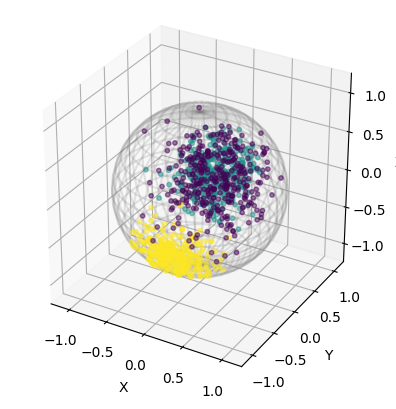

In [5]:
# Plot in 3-D

gplot(points, space="S2", marker="o", s=10, alpha=0.5, c=labels)

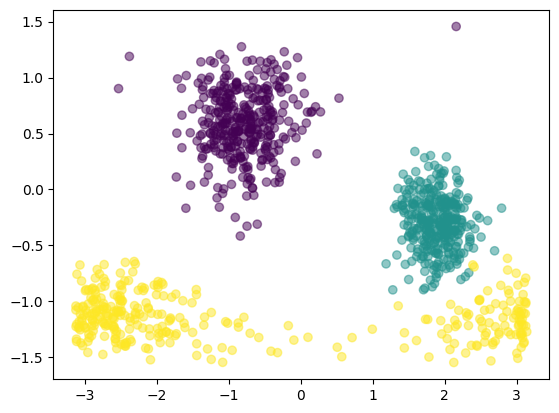

In [6]:
# Project to 2-D (Mercator)


def mercator_projection(points):
    """
    Perform Mercator projection from 3D to 2D for coordinates on a unit sphere.
    Assumes x, y, and z are NumPy arrays and ||x|| = 1.
    """

    # Calculate latitude (phi)
    phi = np.arcsin(points[:, 2])

    # Calculate longitude (lambda)
    lambda_ = np.arctan2(points[:, 1], points[:, 0])

    return np.stack([lambda_, phi], axis=1)


points_2d = mercator_projection(points)

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, alpha=0.5)

In [7]:
# Try it out:

X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.2, random_state=0)

# Hypersphere
hsdt = HypersphereDecisionTreeClassifier(max_depth=5)
hsdt.fit(X_train, y_train)
y_pred = hsdt.predict(X_test)
print("Hypersphere:", accuracy_score(y_test, y_pred))

# Euclidean
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Euclidean:", accuracy_score(y_test, y_pred))

Hypersphere: 0.97
Euclidean: 0.99


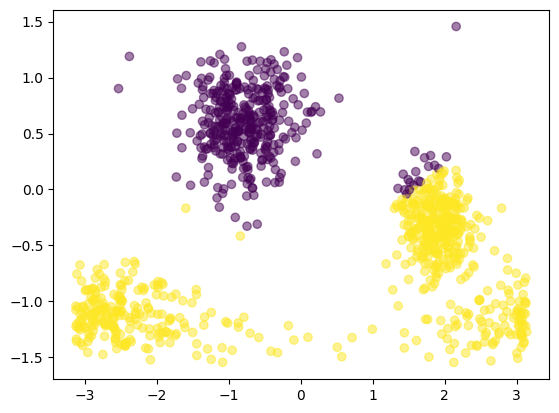

In [8]:
# Let's visualize a decision boundary: hypersphere case

node = hsdt.tree  # Can vary this
colors = np.sign(hsdt._dot(points, node.feature, node.theta))

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)

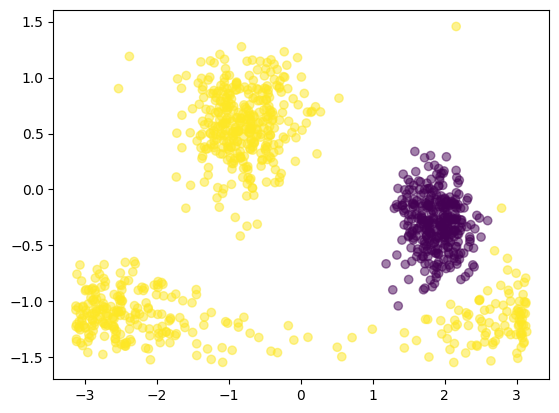

In [9]:
# Let's visualize a decision boundary: hypersphere case

index = 0
colors = points[:, dt.tree_.feature[index]] < dt.tree_.threshold[index]

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


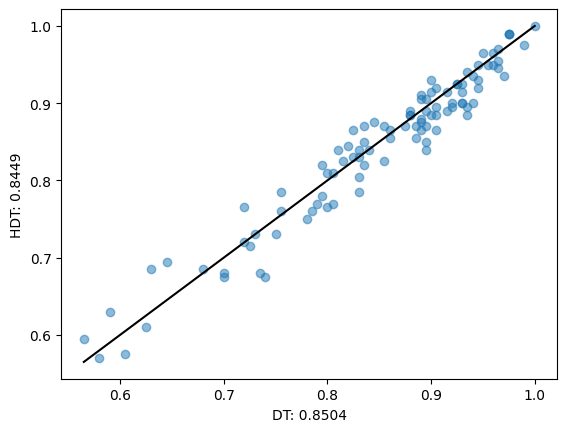

LDT: 0.8516


In [12]:
# Try a bunch of different versions:

# Hyperparameters
MAX_DEPTH = 8
N_CLASSES = 4
N_DIM = 2
NOISE_STD = 0.5

# Some geomstats objects
manifold = Hypersphere(dim=N_DIM)
origin = np.array([1.0] + [0.0] * N_DIM)

# Main loop
dt_accs = []
hdt_accs = []
ldt_accs = []
for _ in tqdm(range(100)):
    X, y = random_vmf(n_means=N_CLASSES, dim=N_DIM)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Hyperbolic decision tree
    hdt = HypersphereDecisionTreeClassifier(max_depth=MAX_DEPTH, candidates="grid")
    hdt.fit(X_train, y_train)

    # Euclidean decision tree + hyperboloid
    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt.fit(X_train, y_train)

    # Euclidean decision tree + log map
    X_train_log = manifold.metric.log(X_train, base_point=origin)
    X_test_log = manifold.metric.log(X_test, base_point=origin)
    dt_log = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt_log.fit(X_train_log, y_train)

    dt_accs.append(accuracy_score(y_test, dt.predict(X_test)))
    hdt_accs.append(accuracy_score(y_test, hdt.predict(X_test)))
    ldt_accs.append(accuracy_score(y_test, dt_log.predict(X_test_log)))


# Plotting code
plt.scatter(dt_accs, hdt_accs, alpha=0.5)
plt.xlabel(f"DT: {np.mean(dt_accs):.4f}")
plt.ylabel(f"HDT: {np.mean(hdt_accs):.4f}")
minval = np.min([np.min(dt_accs), np.min(hdt_accs)])
plt.plot([minval, 1], [minval, 1], c="black")
plt.show()
print(f"LDT: {np.mean(ldt_accs):.4f}")